# PyTorch MNIST Example

The MNIST dataset iss a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. 

It consists of 60,000 training images and 10,000 testing images.

![MNIST Examples](mnist.png)

## Import all the necesary libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import time

## Download the MNIST Train and Test set 
Using the torch.utils.data DataLoader, we shuffle the data and set the batch size to be 256

In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), 
]), )

cuda = torch.cuda.is_available()

# More on Dataloaders next week
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args) 
test_loader = dataloader.DataLoader(test, **dataloader_args)


## Compute basic data statistics
It is always important to know the shape of the data, as well as the min/max and mean/variance

In [3]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Visualize a few training samples
Using the matplotlib.pyplot library, we can visualize our input data.


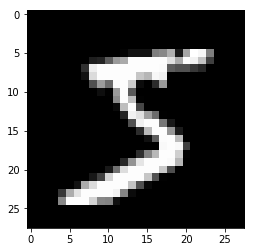

In [4]:
# Visualize a training instance with matplotlib
plt.imshow(train.train_data.cpu().numpy()[0], cmap='gray')

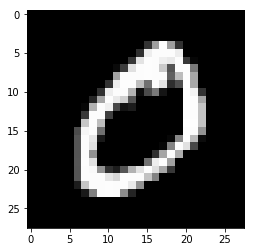

In [5]:
plt.imshow(train.train_data.cpu().numpy()[1], cmap='gray')

## Define our Neural Network Model 
We define our model using the torch.nn.Module class

In [6]:
# SIMPLE MODEL DEFINITION
class Simple_MLP(nn.Module):
    def __init__(self, size_list):
        super(Simple_MLP, self).__init__()
        layers = []
        self.size_list = size_list
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.size_list[0]) # Flatten the input
        return self.net(x)



## Create the model and define the Loss and Optimizer
We create an instance of our Simple_MLP model by passing it a list of layer sizes. The input layer contains 28*28 = 784 neurons. We define a single hidden layer of size 256, and our output will be the class probabilities for each of the 10 digits (0-9). 

Since this is a classification task, we will use Cross Entropy Loss. We define our criterion using the torch.nn.CrossEntropyLoss.

In order to train our network, we use the torch.optim.Adam optimizer.

In [8]:
model = Simple_MLP([784, 256, 10])
criterion = nn.CrossEntropyLoss()
print(model)

optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


## Create a function that will train the network for one iteration

In [9]:
def train_iteration(model, train_loader, criterion, optimizer):
    model.train()
    model.to(device)

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   
        data = data.to(device)
        target = target.long().to(device)

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

## Create a function that will evaluate our network's performance on the test set

In [10]:
def test_iteration(model, test_loader, criterion):
    model.eval()
    model.to(device)

    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0

    for batch_idx, (data, target) in enumerate(test_loader):   
        data = data.to(device)
        target = target.long().to(device)

        outputs = model(data)

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += target.size(0)
        correct_predictions += (predicted == target).sum().item()

        loss = criterion(outputs, target).detach()
        running_loss += loss.item()


    running_loss /= len(test_loader)
    acc = (correct_predictions/total_predictions)*100.0
    print('Testing Loss: ', running_loss)
    print('Testing Accuracy: ', acc, '%')
    return running_loss, acc


## Train the model for N epochs
We call our training and testing functions in a loop, while keeping track of the losses and accuracy. 

In [11]:
n_epochs = 10
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss = train_iteration(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_iteration(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*20)

Training Loss:  0.4463767190562918 Time:  2.183371067047119 s
Testing Loss:  0.22441026270389558
Testing Accuracy:  93.55 %
Training Loss:  0.20037665233967153 Time:  1.5822546482086182 s
Testing Loss:  0.1594692725688219
Testing Accuracy:  95.28999999999999 %
Training Loss:  0.145920038191562 Time:  1.659080982208252 s
Testing Loss:  0.1271239198744297
Testing Accuracy:  96.2 %
Training Loss:  0.11333471340067844 Time:  1.7665965557098389 s
Testing Loss:  0.1171699583530426
Testing Accuracy:  96.71 %
Training Loss:  0.09173299218428896 Time:  2.237760543823242 s
Testing Loss:  0.09552716864272952
Testing Accuracy:  97.08 %
Training Loss:  0.07590515455825532 Time:  1.6450963020324707 s
Testing Loss:  0.08974073799327016
Testing Accuracy:  97.23 %
Training Loss:  0.06261752489557926 Time:  1.6371984481811523 s
Testing Loss:  0.08300091531127692
Testing Accuracy:  97.54 %
Training Loss:  0.053682397305965426 Time:  1.6549930572509766 s
Testing Loss:  0.07628770703449846
Testing Accuracy

## Visualize Training Data

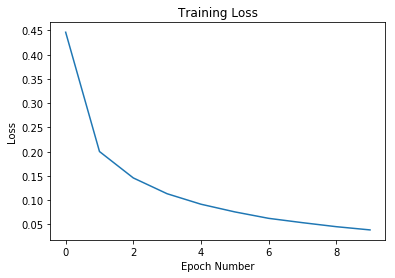

In [12]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss)



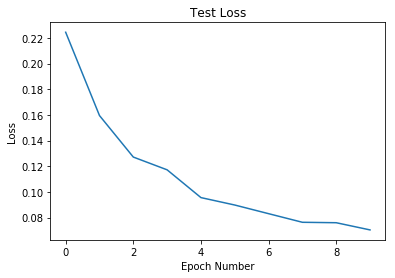

In [13]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Test_loss)


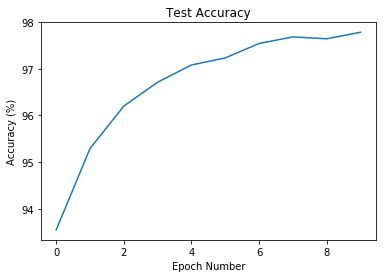

In [14]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)

